In [1]:
import tools
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import base
import anz
import tools
import pandas as pd
import data_config
import viz
from scipy.signal import savgol_filter
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({'font.size': 16})

from pathlib import Path
path = Path(os.getcwd())
project_path = path.parent.absolute()
figure_path = os.path.join(project_path, '_FIGURES')

In [2]:
mice_dict = data_config.pilot.mice_dict


In [3]:
from collections import defaultdict
dd = defaultdict(list)
for mouse, (dates, epochs) in mice_dict.items():
    trial_success_per_day = []
    for date in dates:
        analyzed_dir = os.path.join(r'C:\Users\Peter\Desktop\ANALYZED', mouse, date)
        csv = os.path.join(analyzed_dir, 'notes.csv')
        df = pd.read_csv(csv)
        mask = df['mask'].to_numpy() > 0
        save_dir = os.path.join(os.getcwd(), '_FIGURES')

        label_regions_per_video, label_names = anz._get_labels(
            os.path.join(analyzed_dir, 'LABELS'))
        trial_outcomes = []
        grab_outcomes = []
        trial_success = []
        for i, label_regions in enumerate(label_regions_per_video):
            dropped_regions = label_regions['dropped']
            grabbed_regions = label_regions['grab']
            chew_regions = label_regions['chew']
            # chew region has to be greater than 50 consecutive
            chew_regions = [x for x in chew_regions if (x[1]-x[0]) > 50]
            # some insurance pellet drops at the start of trials, filter that out
            dropped_regions = [x for x in dropped_regions if x[0] > 30]
            outcome = anz.outcome_truth_table(dropped_regions,
                                              chew_regions,
                                              grabbed_regions)
            trial_outcomes.append(outcome)
            grab_outcome = anz.grab_truth_table(outcome,
                                                grabbed_regions,
                                                chew_regions,
                                                dropped_regions)
            grab_outcomes.append(grab_outcome)
            if not mask[i]:
                trial_success.append(np.nan)
            elif outcome in [base.OUTCOME.SUCCESS or base.OUTCOME.DROP_FP]:
                trial_success.append(1)
            else:
                trial_success.append(0)
        trial_success_per_day.append(trial_success)

    s = np.nan
    for i, epoch in enumerate(epochs):
        epoch_data = []
        start_ix = dates.index(epoch[0])
        end_ix = dates.index(epoch[2])

        epoch_data.append(trial_success_per_day[start_ix][epoch[1]:])
        for j in range(start_ix+1, end_ix):
            epoch_data.append(trial_success_per_day[j][:])
        epoch_data.append(trial_success_per_day[end_ix][:epoch[3]])
        epoch_data = [x for y in epoch_data for x in y if x is not np.nan]

        dd['Mouse'].append(mouse)
        dd['Epoch'].append(i)
        dd['Success Rate'].append(epoch_data)
        l = len(epoch_data)
        if np.isnan(s):
            s = 0-l
        dd['Trials'].append(np.arange(s, s + l))
        s += l

more than 1 dropped region
more than 1 dropped region
more than 1 dropped region
more than 1 dropped region


c:\users\peter\anaconda3\envs\deg_env\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\users\peter\anaconda3\envs\deg_env\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


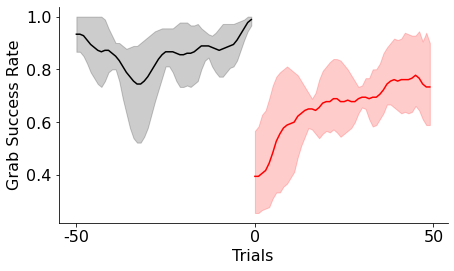

Figure saved at: C:\Users\Peter\Desktop\behavioral_analysis\_FIGURES\success_vs_trials\fig


In [5]:
df = pd.DataFrame(dd)
window_len = 9
epoch_0 = 50
epoch_1 = 50

fig = plt.figure(figsize=(9, 5))
rect = [0.25, 0.25, 0.6, 0.6]
ax = fig.add_axes(rect)

td = defaultdict(list)
temp = df.query("Epoch == 0")
epoch_0_success = np.array([x[-epoch_0:] for x in temp['Success Rate']])\
    .astype(float)
for i, x in enumerate(epoch_0_success):
    y = tools.smooth(x, window_len=window_len, window='flat')
    y = tools.smooth(y, window_len=5, window='flat')
    for j, yv in enumerate(y):
        td['x'].append(-len(y)+j)
        td['y'].append(yv)
        # td['mouse'].append(i)
        # td['epoch'].append(0)

sns.lineplot('x', 'y', data=td, ax=ax, color='black')

td = defaultdict(list)
temp = df.query("Epoch == 1")
epoch_1_success = np.array([x[:epoch_1] for x in temp['Success Rate']])\
    .astype(float)
for i, x in enumerate(epoch_1_success):
    y = tools.smooth(x, window_len=window_len, window='flat')
    y = tools.smooth(y, window_len=5, window='flat')
    for j, yv in enumerate(y):
        td['x'].append(j)
        td['y'].append(yv)
        # td['mouse'].append(i)
        # td['epoch'].append(1)

sns.lineplot('x', 'y', data=td, ax=ax, color='red')

plt.xticks([-epoch_0, 0, epoch_1], [-epoch_0, 0, epoch_1])
plt.xlabel('Trials')
plt.ylabel('Grab Success Rate')
sns.despine()

import plot_tools
plot_tools.save_fig(os.path.join(figure_path, 'success_vs_trials'), 'fig',
                    show=True)